<a href="https://colab.research.google.com/github/pollyjuice74/5G-Decoder/blob/main/LTD_model_reg_LDPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/pollyjuice74/5G-Decoder
!pip install sionna

Cloning into '5G-Decoder'...
remote: Enumerating objects: 1506, done.
remote: Counting objects: 100% (1506/1506), done.
remote: Compressing objects: 100% (566/566), done.
remote: Total 1506 (delta 952), reused 1462 (delta 926), pack-reused 0 (from 0)
Receiving objects: 100% (1506/1506), 2.24 MiB | 11.29 MiB/s, done.
Resolving deltas: 100% (952/952), done.
INFO: pip is looking at multiple versions of ipywidgets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of ipywidgets to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.6/271.6 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.3/384.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [3]:
import tensorflow as tf
import random
import numpy as np
import time
from scipy.sparse import issparse, csr_matrix

from sionna.fec.utils import generate_reg_ldpc, load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder

import os
# os.chdir('../..')
if os.path.exists('5G-Decoder'):
    os.rename('5G-Decoder', '5G_Decoder')
os.chdir('5G_Decoder/adv_nn')

from dataset import *
from attention import *
from channel import *
from args import *
from model_functs import *
from models import *

Loading LDPC code
Setting n to:  60
Number of edges (VN perspective):  180
Number of edges (CN perspective):  180
Generated regular (3,6) LDPC code of length n=60
Code rate is r=0.500.
(30, 60) (2, 60)


<tf.Tensor: shape=(30, 2), dtype=int32, numpy=
array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)>

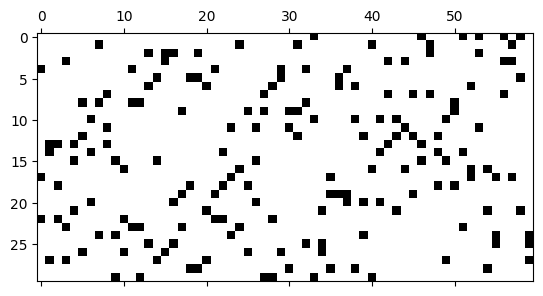

In [5]:
print("Loading LDPC code")
pcm, k, n, coderate = generate_reg_ldpc(v=3,
                                        c=6,
                                        n=60,
                                        allow_flex_len=True,
                                        verbose=True)

# pcm = tf.cast(pcm, dtype=tf.int32)
encoder = LinearEncoder(pcm, is_pcm=True, dtype=tf.int32)

batch_size = 2  # For multiple codewords
b = tf.random.uniform((batch_size, k), minval=0, maxval=2, dtype=tf.int32)
c = encoder(b)
print(pcm.shape, c.shape)
pcm @ tf.transpose(c) % 2

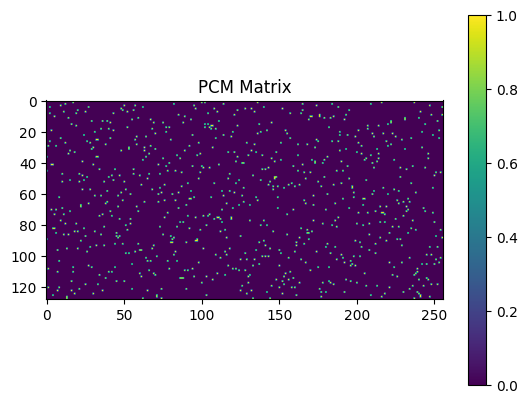

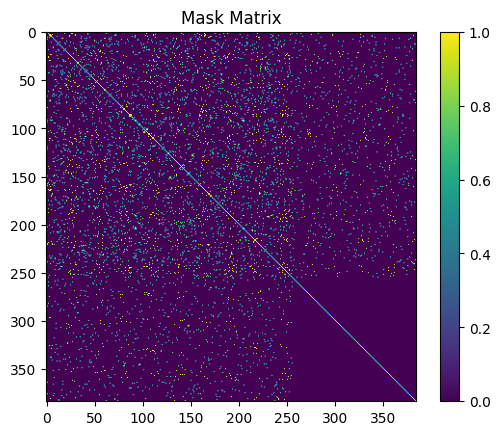

In [37]:
# for e2e model
from sionna.utils import BinarySource, ebnodb2no
from sionna.mapping import Mapper, Demapper
from sionna.channel import AWGN
import matplotlib.pyplot as plt


class Args():
    def __init__(self, t_layers=4, d_model=128, heads=8, lr=5e-4,
                       batch_size=160, batch_size_eval = 150,
                       eval_train_iter=50, save_weights_iter=100,
                       c=6, v=3, num_iter_bp_eval=100, mask_division_shape=5,
                       ebno_db_eval=2.5,
                       ebno_db_min=0., ebno_db_max=4., ebno_db_stepsize=0.25,
                       traindata_len=500, testdata_len=250,
                       mc_batch_size=200, mc_iters=500, epochs=1000000):
        # model data
        self.t_layers = t_layers
        self.d_model = d_model
        self.heads = heads
        self.mask_division_shape = mask_division_shape
        # Evaluating
        self.ns_eval = list(range(90, 256, 15))
        self.v = v
        self.c = c
        self.num_iter_bp_eval = num_iter_bp_eval
        # training data
        self.lr = lr
        self.batch_size = batch_size
        self.traindata_len = traindata_len
        self.testdata_len = testdata_len
        self.epochs = epochs

        self.ebno_db_min = ebno_db_min
        self.ebno_db_max = ebno_db_max
        self.ebno_db_stepsize = ebno_db_stepsize

        self.ebno_db_eval = ebno_db_eval
        self.eval_train_iter = eval_train_iter
        self.save_weights_iter = save_weights_iter
        self.batch_size_eval = batch_size_eval

        # simulation
        self.mc_batch_size = mc_batch_size
        self.mc_iters = mc_iters

        # code data
        self.code = type('Code', (), {})()


from tensorflow.keras.layers import MultiHeadAttention, Dense, LayerNormalization, Dropout, Layer
from tensorflow import einsum, multiply

class LinearMHAttention( Layer ):
    def __init__(self, num_heads, key_dim, mask_shape, mask_division_shape, dropout=0.1):
        super().__init__()
        assert (key_dim % num_heads) == 0, 'dimension must be divisible by the number of heads'
        self.dims = key_dim
        self.heads = num_heads
        self.dim_head = self.dims // self.heads

        self.k_proj = self.get_k_proj(mask_shape, mask_division_shape) # n+m
        self.proj_k = None
        self.proj_v = None

        self.to_q, self.to_k, self.to_v = [ Dense(self.dims, use_bias=False) for _ in range(3) ]
        self.to_out = Dense(self.dims)
        self.dropout = Dropout(dropout) # to d-dimentional embeddings

    def build(self, input_shape):
        n_value = input_shape[1] # (b, n, d)
        # Creates shape (n,k_proj) proj matrices for key and value
        self.proj_k = self.add_weight("proj_k", shape=[n_value, self.k_proj], initializer=GlorotUniform())
        self.proj_v = self.add_weight("proj_v", shape=[n_value, self.k_proj], initializer=GlorotUniform())

    def get_k_proj(self, mask_shape, mask_division_shape):
        mask_length = mask_shape[1] # mask_shape (b, n+m, n+m)
        # gets dimention for linear tranformer vector projection
        for k_proj in range(mask_length // mask_division_shape, 0, -1): # starts at half the mask length to 0
            if mask_length % k_proj == 0:
                return tf.cast(k_proj, tf.int32)

    def call(self, query, value, key=None, attention_mask=None, training=False): # O(n)
        shape = tf.shape(query) # (b, n, d)
        b = tf.cast(shape[0], tf.int32)
        n = tf.cast(shape[1], tf.int32)

        key = value if key is None else key

        assert query.shape[-1] is not None, "The last dimension of x is undefined."

        query, key, val = self.to_q(query), self.to_k(key), self.to_v(value)

        # Project key and val into k-dimentional space
        key = tf.einsum('bnd,nk->bkd', key, self.proj_k)
        val = tf.einsum('bnd,nk->bkd', val, self.proj_v)

        # Reshape splitting for heads
        query = tf.reshape(query, (b, n, self.heads, self.dim_head))
        key = tf.reshape(key, (b, self.k_proj, self.heads, self.dim_head))
        val = tf.reshape(val, (b, self.k_proj, self.heads, self.dim_head))
        query, key, val = [ tf.transpose(x, [0, 2, 1, 3]) for x in [query, key, val] ]

        # Low-rank mask (n,k_proj)
        mask = tf.expand_dims(attention_mask, axis=-1)
        mask = tf.image.resize(mask, [n, self.k_proj], method='nearest')
        mask = tf.reshape(mask, (1, 1, n, self.k_proj))

        # Main attn logic: sftmx( q@k / d**0.5 ) @ v
        scores = tf.einsum('bhnd,bhkd->bhnk', query, key) / (tf.sqrt( tf.cast(self.dim_head, dtype=tf.float32) ))
        scores += (mask * -1e9) if mask is not None else 0.
        attn = tf.nn.softmax(scores, axis=-1) # (b,h,n,k_proj)
        attn = self.dropout(attn) if training else attn
        out = tf.einsum('bhnk,bhkd->bhnd', attn, val)

        # Reshape and pass through out layer
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, (b, n, -1))
        return self.to_out(out)


class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, linear, mask_shape, mask_division_shape, dropout_rate=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.mha = (
            LinearMHAttention(num_heads=num_heads,
                              key_dim=d_model,
                              mask_shape=mask_shape,
                              mask_division_shape=mask_division_shape,
                              dropout=dropout_rate)
            if linear
            else MultiHeadAttention(num_heads=num_heads,
                                    key_dim=d_model,
                                    dropout=dropout_rate)
        )
        self.ffn = tf.keras.Sequential([
            Dense(d_ff, activation='relu'),
            Dense(d_model),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, mask, training):
        # Multi-Head Attention
        attn_output = self.mha(x, x, attention_mask=mask, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Add & Normalize

        # Feedforward Network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Normalize
        return out2


class Decoder( Layer ):
    def __init__(self,
                 args,
                 linear=True,
                 verbose=True,
                 mask_division_shape=2,
                 dropout_rate=0.1,
                 rate_matching=False):
        super().__init__()
        code = args.code
        self.pcm = tf.cast(code.H, dtype=tf.int32)

        # shapes
        self._m, self._n = self.pcm.shape
        self._k = self._n - self._m
        self.dims = args.d_model
        self.batch_size = args.batch_size
        self.rate_matching = rate_matching

        # mask
        self.mask = self.create_mask(self.pcm)
        if verbose:
            for matrix, title in zip([self.pcm, tf.squeeze(self.mask, axis=0)], ["PCM Matrix", "Mask Matrix"]):
                plt.imshow(matrix, cmap='viridis'); plt.colorbar(); plt.title(title); plt.show()

        # layers
        self.node_embeddings = Dense(self.dims)
        self.encoder_blocks = [
            TransformerEncoderBlock(
                d_model=args.d_model,
                num_heads=args.heads,
                d_ff=args.d_model * 4,
                linear=linear,
                mask_shape=self.mask.shape,
                mask_division_shape=mask_division_shape,
                dropout_rate=dropout_rate,
            )
            for _ in range(args.t_layers)
        ]
        self.forward_channel = Dense(1)
        self.dropout = Dropout(dropout_rate)
        self.to_n = Dense(self._n)

    def create_mask(self, H):
        # Initialize diagonal identity mask
        mask = tf.eye(2 * self._n - self._k, dtype=tf.float32).numpy()

        for i in range(self._m):
            # Get indices where H[i] == 1
            indices = np.where(H[i].numpy() == 1)[0]  # Convert TensorFlow tensor to NumPy array

            # Nested loop over indices
            for j in indices:
                for k in indices:
                    if j != k:
                        mask[j, k] = 1
                        mask[k, j] = 1
                        mask[self._n + i, j] = 1
                        mask[j, self._n + i] = 1

        # Convert the mask back to a TensorFlow tensor
        mask = tf.convert_to_tensor(mask, dtype=tf.float32)

        # Expand mask's batch size for tf MHA
        mask = tf.expand_dims(mask, axis=0)  # Shape: (1, n+m, n+m)
        return mask

    def get_syndrome(self, vn_vector, from_llr=True):
        """ Calculate syndrome (pcm @ r.T = 0) if r is correct in binary """
        vn_vector = tf.transpose(vn_vector) # (n,b)
        bin_vector = llr_to_bin(vn_vector) if from_llr else vn_vector
        return tf.cast( (self.pcm @ bin_vector) % 2, dtype=tf.float32) # (m,n)@(n,b)->(m,b)

    def call(self, x_nodes, training=False):
        # Embed cn/vn nodes vector
        x_nodes_embedded = self.node_embeddings( x_nodes ) # (b, n+m, hidden_dims)
        # Pass through each encoder block
        for block in self.encoder_blocks:
            x_nodes = block(x_nodes_embedded,
                            mask=self.mask,
                            training=training)
        x_nodes = tf.squeeze( self.forward_channel(x_nodes), axis=-1 ) # (b, n+m, hidden_dims)->(b, n+m)
        x_nodes = self.dropout(x_nodes) if training else x_nodes
        llr_hat = self.to_n(x_nodes) # (b, n+m)->(b,n)
        return llr_hat


class E2EModel(tf.keras.Model):
    def __init__(self, encoder, decoder, k, n, return_infobits=False, es_no=False, rate_matching=False):
        super().__init__()

        self._n = n
        self._k = k
        self._m = n - k
        self.rate_matching = rate_matching

        self._binary_source = BinarySource(dtype=tf.int32)
        self._num_bits_per_symbol = 2
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol)
        self._channel = AWGN()
        self._decoder = decoder
        self._encoder = encoder
        self._return_infobits = return_infobits
        self._es_no = es_no

    @tf.function(jit_compile=False)
    def call(self, batch_size, ebno_db, training=False):

        # no rate-adjustment for uncoded transmission or es_no scenario
        if self._decoder is not None and self._es_no==False:
            no = ebnodb2no(ebno_db, self._num_bits_per_symbol, self._k/self._n)
        else: #for uncoded transmissions the rate is 1
            no = ebnodb2no(ebno_db, self._num_bits_per_symbol, 1)

        b = self._binary_source([batch_size, self._k])
        if self._encoder is not None:
            c = self._encoder(b)
        else:
            c = b

        # check that rate calculations are correct
        assert self._n==c.shape[-1], "Invalid value of n."

        # zero padding to support odd codeword lengths
        if self._n%2==1:
            c_pad = tf.concat([c, tf.zeros([batch_size, 1])], axis=1)
        else: # no padding
            c_pad = c
        x = self._mapper(c_pad)

        y = self._channel([x, no])
        llr = self._demapper([y, no])

        # remove zero padded bit at the end
        if self._n%2==1:
            llr = llr[:,:-1]

        # decoder input nodes
        if not self.rate_matching:
            syndrome = tf.reshape( self._decoder.get_syndrome(llr),
                                  (batch_size, self._m) ) # (m,n)@(n,b)->(m,b) check nodes
            x_nodes = tf.concat([llr, syndrome], axis=1)[:, :, tf.newaxis] # (b, n+m, 1)
        else:
           x_nodes = llr # (b, n, 1)

        # and run the decoder
        if self._decoder is not None:
            ############################
            c_hat_logits = self._decoder(x_nodes, training=training)
            ############################
        c_hat = tf.cast(tf.greater(c_hat_logits, 0.0), tf.int32)

        if self._return_infobits:
            return b, c_hat, c_hat_logits, llr
        else:
            return c, c_hat, c_hat_logits, llr


# args for decoder/discriminator
args = Args()
args.code.H = pcm
args.m, args.n = pcm.shape
args.k = k

ltd_decoder = Decoder(args, linear=False) # Linear Transformer Diffusion (LTD) Decoder

e2e_ltd = E2EModel(encoder, ltd_decoder, k, n)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
@staticmethod
def bin_to_llr(x):
    """
    Converts binary values (0 or 1) to log-likelihood ratios (LLRs), clipping values to ±20 for numerical stability.
    Args:
        x (Tensor): Binary input tensor with values 0 or 1.
    Returns:
        Tensor: Tensor of LLR values with clipped range.
    """
    llr_vector = tf.where(x == 0, -20, 20)
    return llr_vector

@staticmethod
def llr_to_bin(c):
    """
    Converts log-likelihood ratios (LLRs) to binary values based on their sign.
    Args:
        c (Tensor): Tensor of LLR values.
    Returns:
        Tensor: Binary tensor with values 0 or 1.
    """
    return tf.cast(tf.greater(c, 0), tf.int32)

def load_weights(model, checkpoint_path):
    """
    Loads the model's weights from a specified checkpoint directory.
    Args:
        model (tf.keras.Model): The model whose weights need to be restored.
        checkpoint_path (str): File path where checkpoint files are stored.
    """
    checkpoint = tf.train.Checkpoint(decoder=model._decoder)
    try:
        checkpoint.restore(checkpoint_path).assert_existing_objects_matched()
        print(f"Successfully restored weights from {checkpoint_path}")
    except AssertionError:
        print("No checkpoint found. Starting training from scratch.")

def save_weights(model, checkpoint_dir, weight_type='last', ber=None):
    """
    Saves the model's weights to a specified checkpoint directory, optionally including BER in the filename.

    Args:
        model (tf.keras.Model): The model whose weights need to be saved.
        checkpoint_dir (str): Directory path where checkpoint files will be saved.
        weight_type (str): Type of weights to save ('best' or 'last').
        ber (float, optional): BER value to include in the filename if saving the best weights.
    """
    checkpoint = tf.train.Checkpoint(decoder=model._decoder)
    if weight_type == 'best' and ber is not None:
        save_path = os.path.join(checkpoint_dir, f'{weight_type}_weights_ber_{ber:.5e}')
    else:
        save_path = os.path.join(checkpoint_dir, f'{weight_type}_weights')
    checkpoint.save(save_path)
    print(f"Saved {weight_type} weights to {save_path}")

def parse_best_ber_from_filename(checkpoint_dir):
    """
    Parses the best BER value from filenames in the checkpoint directory.

    Args:
        checkpoint_dir (str): Directory path where checkpoint files are stored.

    Returns:
        float: The best BER value parsed from the filenames.
    """
    import re
    import os

    best_ber = float('inf')  # Initialize the best BER as infinity
    try:
        for filename in os.listdir(checkpoint_dir):
            match = re.search(r'best_weights_ber_(\d+\.\d+e[+-]?\d+)', filename)
            if match:
                ber = float(match.group(1))  # Extract BER from filename
                best_ber = min(best_ber, ber)  # Update the best BER if a smaller value is found
    except FileNotFoundError:
        print(f"No checkpoint directory found at {checkpoint_dir}")
    print(f"Best BER found: {best_ber}")
    return best_ber

def visualize_weights(model):
    """
    Visualizes the trainable weights of the model as heatmaps, updating them in place during training.
    Args:
        model (tf.keras.Model): The model whose weights are visualized.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.ion()  # Turn on interactive mode
    num_weights = len(model.trainable_weights)
    fig, axs = plt.subplots(1, num_weights, figsize=(5 * num_weights, 5))

    # Ensure axs is iterable (handles single axis case)
    if num_weights == 1:
        axs = [axs]

    print(model.trainable_weights)
    for i, var in enumerate(model.trainable_weights):
        var_name = var.name
        var_value = var.numpy()

        axs[i].clear()  # Clear the axis to avoid overlapping

        if len(var_value.shape) == 1:  # 1D tensor (e.g., bias)
            axs[i].plot(var_value)
            axs[i].set_title(f'{var_name} (1D)')
        elif len(var_value.shape) == 2:  # 2D tensor (e.g., weights)
            sns.heatmap(var_value, cmap="viridis", ax=axs[i], cbar=True)
            axs[i].set_title(f'{var_name} (2D)')
        else:  # Higher-dimensional tensors
            axs[i].text(0.5, 0.5, f"{var_name}: Shape {var_value.shape} not visualizable",
                        ha='center', va='center', fontsize=10)
            axs[i].set_title(f'{var_name} (Not 1D/2D)')

    plt.draw()  # Update the figure with new data
    plt.pause(0.5)  # Pause briefly to allow visualization updates

    plt.ioff()  # Turn off interactive mode
    plt.show()

# SGD update iteration
@tf.function(jit_compile=False)
def train_step(model, loss_fn, optimizer, batch_size):
    """
    Performs one training step with a batch of data, updating weights and saving the best BER weights if applicable.

    Args:
        model (tf.keras.Model): The model to be trained.
        loss_fn (tf.keras.losses.Loss): Loss function to calculate the error.
        optimizer (tf.keras.optimizers.Optimizer): Optimizer to update the model weights.
        batch_size (int): Number of samples in the training batch.

    Returns:
        Tuple: Ground truth binary labels, predicted LLR values, and updated best BER.
    """
    # train for random SNRs within a pre-defined interval
    ebno_db = tf.random.uniform([batch_size, 1],
                                minval=args.ebno_db_min,
                                maxval=args.ebno_db_max)

    with tf.GradientTape() as tape:
        c, c_hat, c_hat_logits, llr_channel = model(batch_size, ebno_db, training=True)

        loss_value = loss_fn(c, c_hat_logits)
        ber = compute_ber(c, c_hat)

    # and apply the SGD updates
    weights = model.trainable_weights
    grads = tape.gradient(loss_value, weights) # variables
    optimizer.apply_gradients(zip(grads, weights))
    return c, c_hat_logits, ber

def test_step(model, args, loss_fn, learning_rate, epoch):
    """
    Evaluates the model on a batch of data, calculating loss, bit error rate (BER), and timing.
    Args:
        model (tf.keras.Model): The model to be evaluated.
        args (Namespace): Arguments containing evaluation parameters.
        loss_fn (tf.keras.losses.Loss): Loss function to calculate the error.
        learning_rate (float): Current learning rate of the optimizer.
        epoch (int): Current epoch of training.
    """
    ebno_db = tf.random.uniform([args.batch_size, 1],
                                 minval=args.ebno_db_eval,
                                 maxval=args.ebno_db_eval)
    # measure time for call
    time_start = time.time()
    c, c_hat, c_hat_logits, llr_channel = model(args.batch_size, ebno_db)
    duration = time.time() - time_start # in s

    # loss
    loss_value = loss_fn(c, c_hat_logits)
    # ber pred
    ber = compute_ber(c, c_hat).numpy()
    bler = compute_bler(c, c_hat).numpy()
    # ber original
    c_channel = llr_to_bin(llr_channel)
    channel_ber = compute_ber(c, c_channel).numpy()

    print(f'Training epoch {epoch}/{args.epochs}, LR={learning_rate:.2e}, Loss={loss_value.numpy():.5e}, channel_BER={channel_ber:.3e}, BER={ber:.3e}, BLER={bler:.3e} duration per call: {duration:.9f}s')

def train_dec(model, args, file_name, save_path='/content/drive/My Drive/ECC_weights/', load_decoder_weights=False, visualize_decoder_weights=False):
    """
    Trains the model using a specified training process, evaluates periodically, and saves weights at intervals.
    Args:
        model (tf.keras.Model): The model to be trained.
        args (Namespace): Training arguments including batch size, epochs, learning rate, etc.
        file_name (str): Name of the file to save weights.
        save_path (str): Directory path to save model checkpoints.
        visualize_decoder_weights (bool): Whether to visualize model weights during training.
    """
    # loss
    loss_fn =  tf.keras.losses.BinaryCrossentropy(from_logits=False)
    # optimizer
    scheduler = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=args.lr, decay_steps=args.epochs) # 1000 is size of trainloader
    optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)

    # Load weights if available
    weights_path = os.path.join(save_path, file_name)
    load_weights(model, weights_path) if load_decoder_weights else None

    weights_dir = os.path.dirname(weights_path) # Directory of weights
    best_ber = parse_best_ber_from_filename(weights_dir) # Retrieve or initialize best BER

    print("Training Model...")
    for epoch in range(1, args.epochs + 1):
        _, _, ber = train_step(model,
                              loss_fn,
                              optimizer,
                              args.batch_size)

        # Save the best weights if the current BER is better
        if ber < best_ber:
            save_weights(model, weights_dir, weight_type='best', ber=ber)
            best_ber = ber # Update the best BER

        # eval train iter
        if epoch % args.eval_train_iter == 0:
            test_step(model,
                      args,
                      loss_fn,
                      learning_rate=optimizer.learning_rate.numpy(),
                      epoch=epoch)
            # break

        # save weights iter
        # if epoch % args.save_weights_iter == 0:
            # save_weights(model, weights_dir, weight_type='last')

        # visualize decoder weights
        if visualize_decoder_weights:
            visualize_weights(model)


train_dec(e2e_ltd,
          args,
          file_name='ECCT_pcm_30_60_Tlayers2_dims64/best_weights_ber_3.35833e-01-1',
          load_decoder_weights=True,
          visualize_decoder_weights=False)

NotFoundError: Error when restoring from checkpoint or SavedModel at /content/drive/My Drive/ECC_weights/ECCT_pcm_30_60_Tlayers2_dims64/best_weights_ber_3.35833e-01-1: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for /content/drive/My Drive/ECC_weights/ECCT_pcm_30_60_Tlayers2_dims64/best_weights_ber_3.35833e-01-1
Please double-check that the path is correct. You may be missing the checkpoint suffix (e.g. the '-1' in 'path/to/ckpt-1').

In [ ]:
dir_path = "/content/drive/My Drive/ECC_weights/"
file_path = "ECCT_pcm_30_60_Tlayers2_dims64/best_weights_ber_1.34167e-01-1"
best_weights_path = os.path.join(dir_path, file_path)

load_weights(e2e_ltd, best_weights_path)

Successfully restored weights from /content/drive/My Drive/ECC_weights/ECCT_pcm_30_60_Tlayers2_dims64/best_weights_ber_1.34167e-01-1


In [ ]:
ber_plot = PlotBER(f"Transformer-based Decoding - LDPC, (k,n)=({e2e_ltd._k},{e2e_ltd._n})")
ebno_dbs = np.arange(0, #args.ebno_db_min,
                     8, #args.ebno_db_max,
                     args.ebno_db_stepsize)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.6357e-01 | 1.0000e+00 |        4907 |       30000 |          500 |         500 |         0.2 |reached target block errors
     0.25 | 1.5413e-01 | 1.0000e+00 |        4624 |       30000 |          500 |         500 |         0.2 |reached target block errors
      0.5 | 1.5093e-01 | 1.0000e+00 |        4528 |       30000 |          500 |         500 |         0.2 |reached target block errors
     0.75 | 1.3897e-01 | 1.0000e+00 |        4169 |       30000 |          500 |         500 |         0.2 |reached target block errors
      1.0 | 1.3633e-01 | 1.0000e+00 |        4090 |       30000 |          500 |         500 |         0.2 |reached target block errors
     1.25 | 1.2750e-01 | 1.0000e+00 |        3825 |       30000 |

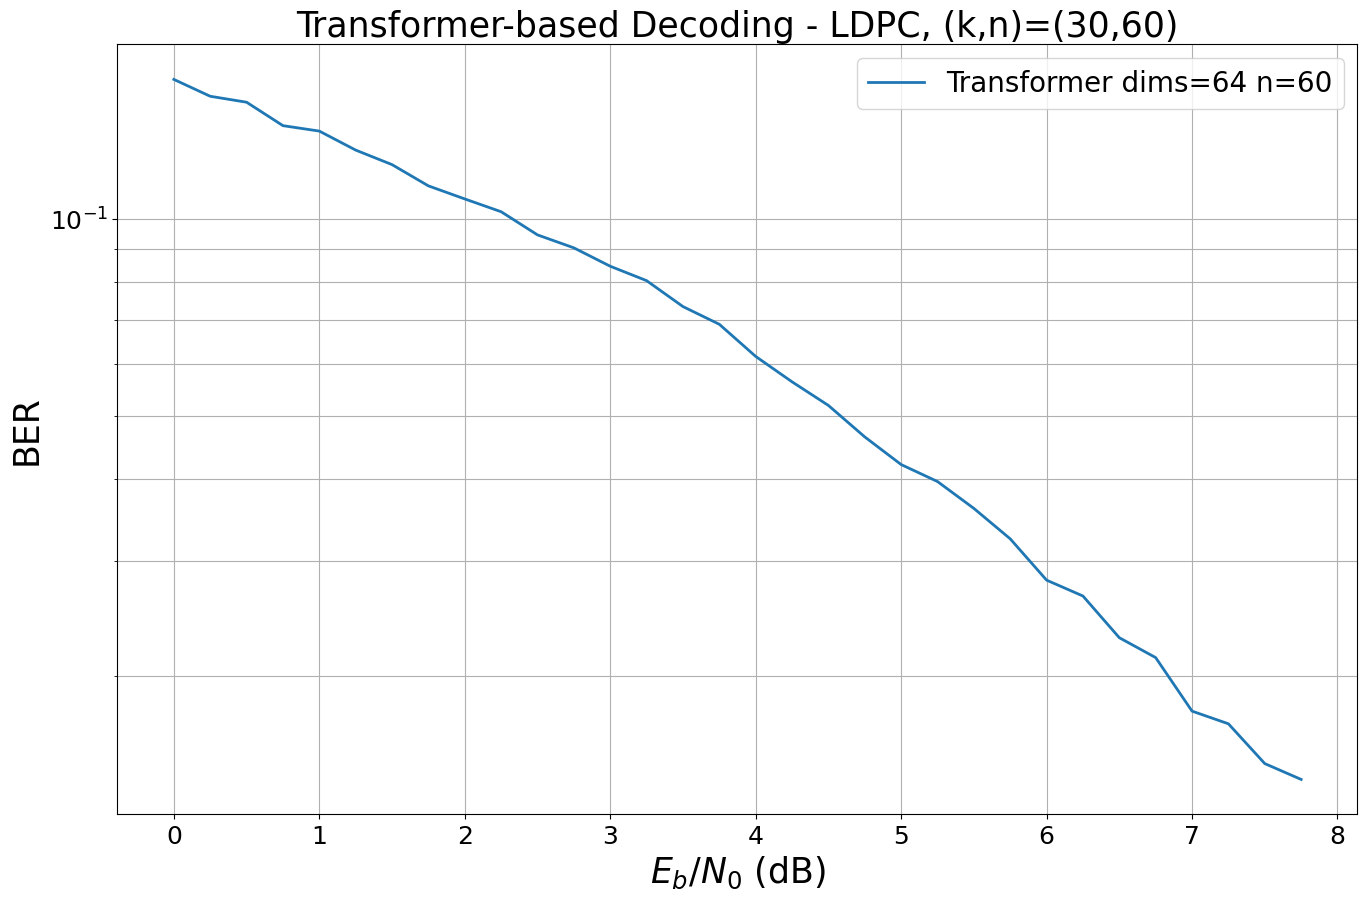

In [ ]:
# and run the BER simulations
ber_plot.simulate(e2e_ltd,
                  ebno_dbs=ebno_dbs,
                  batch_size=100,#args.mc_batch_size,
                  num_target_block_errors=500,
                  legend=f"Transformer dims={e2e_ltd._decoder.dims} n={e2e_ltd._n}",
                  soft_estimates=False,
                  max_mc_iter=100,#args.mc_iters,
                  forward_keyboard_interrupt=False,
                  show_fig=True);

In [38]:
def compare_times(models, eval_iters=5):
    """
    Evaluates the models' time performance for a specified number of iterations.

    Args:
        decoders (dict): Dictionary of decoder names and their corresponding models.
        eval_iters (int): Number of evaluation iterations.
    """
    ebno_db = tf.random.uniform([args.batch_size, 1],
                                 minval=args.ebno_db_eval,
                                 maxval=args.ebno_db_eval)
    model_durations = {name: [] for name in models}

    for name, model in models.items():
        model_durations[name] = []

        for _ in range(eval_iters):
            # measure time for call
            time_start = time.time()
            c, c_hat, c_hat_logits, llr_channel = model(args.batch_size, ebno_db)
            duration = time.time() - time_start # in s

            model_durations[name].append(duration)

     # Convert to NumPy array for statistics
    model_durations_np = {name: np.array(times) for name, times in model_durations.items()}
    return model_durations_np


data = {}
# Compare time performance between Linear and Regular Transformer decoder on varying pcm sizes
for n in args.ns_eval:
    print(f"Evaluating on {n}")
    decoders = []
    while True:
        try:
            # generate new code for each length
            pcm, k, n, coderate = generate_reg_ldpc(v=args.v,
                                                    c=args.c,
                                                    n=n,
                                                    allow_flex_len=True,
                                                    verbose=False)
            break
        except Exception as e:
            pass

    encoder = LinearEncoder(pcm, is_pcm=True, dtype=tf.int32)

    # simulate "conventional" BP performance first
    bp_decoder = LDPCBPDecoder(pcm,
                              num_iter=args.num_iter_bp_eval,
                              hard_out=False)
    e2e_bp = E2EModel(encoder, bp_decoder, k, n, rate_matching=True) # Not really rate-matching but just to bypass syndrome computation

    # args for decoder
    args = Args()
    args.code.H = pcm
    args.m, args.n = pcm.shape
    args.k = k

    lin_trans_decoder = Decoder(args,
                                verbose=False,
                                mask_division_shape=args.mask_division_shape,
                                linear=True) # Linear Transformer Diffusion (LTD) Decoder
    e2e_lin_trans = E2EModel(encoder, lin_trans_decoder, k, n)

    reg_trans_decoder = Decoder(args,
                                verbose=False,
                                linear=False) # Regular Transformer Diffusion (LTD) Decoder
    e2e_reg_trans = E2EModel(encoder, reg_trans_decoder, k, n)

    # Store decoders in a dictionary
    decoders = {
        f"BP Decoder (iters={args.num_iter_bp_eval})": e2e_bp,
        f"Linear Transformer (mask_div={args.mask_division_shape})": e2e_lin_trans,
        "Regular Transformer": e2e_reg_trans
    }
    print(decoders)

    data[str((n-k, n))] = compare_times(decoders)


Evaluating on 90
Stopping - no solution found!
{'BP Decoder (iters=100)': <__main__.E2EModel object at 0x7e43c6a76b60>, 'Linear Transformer (mask_div=5)': <__main__.E2EModel object at 0x7e43c5e219f0>, 'Regular Transformer': <__main__.E2EModel object at 0x7e43c57fd2d0>}
Evaluating on 105
{'BP Decoder (iters=100)': <__main__.E2EModel object at 0x7e43c57d4c40>, 'Linear Transformer (mask_div=5)': <__main__.E2EModel object at 0x7e43c5c60f70>, 'Regular Transformer': <__main__.E2EModel object at 0x7e43c69ee290>}
Evaluating on 120
{'BP Decoder (iters=100)': <__main__.E2EModel object at 0x7e43c85e2cb0>, 'Linear Transformer (mask_div=5)': <__main__.E2EModel object at 0x7e43c65ec3d0>, 'Regular Transformer': <__main__.E2EModel object at 0x7e43c5c61f00>}
Evaluating on 135
Stopping - no solution found!
{'BP Decoder (iters=100)': <__main__.E2EModel object at 0x7e440cc47160>, 'Linear Transformer (mask_div=5)': <__main__.E2EModel object at 0x7e43ce5f2a70>, 'Regular Transformer': <__main__.E2EModel obje

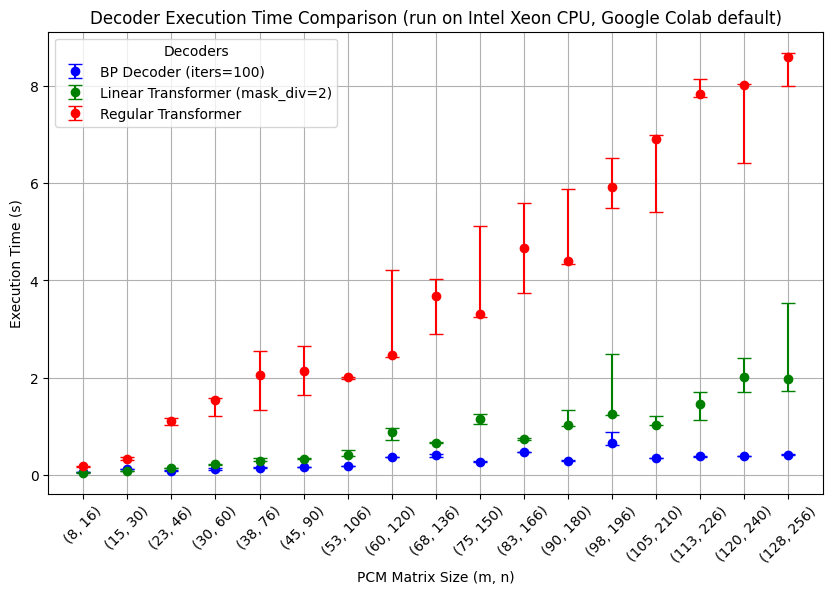

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Extract PCM sizes (x-axis) and ensure execution times are properly structured
pcm_sizes = list(data.keys())  # List of (m, n) tuples
decoders = list(data[pcm_sizes[0]].keys())  # Extract decoder names dynamically

# Convert execution times to NumPy arrays for quartile calculations
execution_times_np = {
    name: np.array([data[pcm_size][name] for pcm_size in pcm_sizes])
    for name in decoders
}

# Plot quartile charts
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'green', 'red']

for i, (name, times) in enumerate(execution_times_np.items()):
    medians = np.median(times, axis=1)
    q1 = np.percentile(times, 25, axis=1)
    q3 = np.percentile(times, 75, axis=1)

    ax.errorbar(range(len(pcm_sizes)), medians, yerr=[medians - q1, q3 - medians],
                fmt='o', label=name, color=colors[i], capsize=5)

# Set x-axis labels to tuple sizes
ax.set_xticks(range(len(pcm_sizes)))
ax.set_xticklabels(pcm_sizes, rotation=45)

ax.set_xlabel("PCM Matrix Size (m, n)")
ax.set_ylabel("Execution Time (s)")
ax.set_title(f"Decoder Execution Time Comparison (run on Intel Xeon CPU, Google Colab default)")
ax.legend(loc='upper left', title="Decoders")
ax.grid(True)
plt.show()
